<a href="https://colab.research.google.com/github/todnewman/coe_training/blob/master/Using_OpenCV_to_Classify_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using OpenCV to Classify Images

Here we will take an trained Imagenet model and perform inference on an image we give the model.

**Author**: W. Tod Newman
##Learning Objectives

   *  Understand how to easly use OpenCV and Imagenet pretrained models in Keras
   *  Evaluate the way that these models classify known images
   *  Develop understanding of transfer learning and these models in particular.

## What is a pre-trained model?
A pre-trained model is trained on a different task than the task at hand but provides a very useful starting point because the features learned while training on the old task are useful for the new task.

## What is Imagenet?
Imagenet is a project created to provide a large image database for research purposes. It contains more than 14 million images which belong to more than 20,000 classes. They also provide bounding box annotations for around 1 million images, which can be used in Object Localization tasks. 

## Pre-trained models already part of Keras
From the ImageNet Large Scale Visual Recognition Challenge  (ILSVRC)  many winning models have been open-sourced. 

These networks are trained for classifying images into one of 1000 categories or classes.

Keras comes bundled with many models. A trained model has two parts – Model Architecture and  Weights. The weights are large files and have to be automatically downloaded ( one-time ). For this example we'll focus on three architectures and we'll instantiate them with imagenet weights.

* VGG16.  A 16 Layer Convolutional Network created by Oxford's Visual Geometries Group that won ILSVRC in 2014.  https://arxiv.org/abs/1409.1556
* InceptionV3.  Created by Google Brain for ILSVRC.  https://arxiv.org/abs/1512.00567
* ResNet.  A 50 layer residual network.  https://arxiv.org/pdf/1512.03385.pdf

In [119]:
import keras
import numpy as np
from keras.applications import vgg16, inception_v3, resnet50
 
#Load the VGG model
vgg_model = vgg16.VGG16(weights='imagenet')
 
#Load the Inception_V3 model
inception_model = inception_v3.InceptionV3(weights='imagenet')
 
#Load the ResNet50 model
resnet_model = resnet50.ResNet50(weights='imagenet')

# Clone the images repository
!git clone https://github.com/todnewman/images
%cd /content/images
!ls -l

Cloning into 'images'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.


In [152]:
# Here's a cool way to see the layers in the models.  Substitute the name of the model you're interested in
print (vgg_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Load new images

To load new images, use the below code.  It will allow you to load images from your own computer.  Otherwise, you'll be able to test with the default images. 

In [15]:
#!wget 'https://www.airforce.gov.au/technology/aircraft/air-combat'
from google.colab import files
original = files.upload()
for fn in original.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(original[fn])))
!ls

Saving clooney smile.bmp to clooney smile.bmp
User uploaded file "clooney smile.bmp" with length 54414 bytes
 air-combat.jpg   'clooney smile.bmp'	     dog.jpg	   test
 bed-bugsalt.jpg   commercial_aircraft.jpg   sample_data


# Function to predict the Image Class

Feed the processed image to the network and get the predictions. The image we got in the previous step should be normalized by subtracting the mean of the ImageNet data. This is because the network was trained on the images after this pre-processing. We follow the following steps to get the classification results.

1) **Preprocess** the input by subtracting the mean Imagenet RGB value from each channel of the images in the batch. This is done using the preprocess_input() function.

2) Get the classification result, which is a Tensor of dimension ( batchsize x 1000 ). This is done by model.predict() function.

3) Convert the result to human-readable labels – The vector obtained above has too many values to make any sense. Keras provides a function decode_predictions() which takes the classification results, sorts it according to the confidence of prediction and gets the class name ( instead of a class-number).The output shows the class ID, class name and the confidence of prediction.

In [0]:
# Small Function intended to walk through a dictionary made up of the keras pre-trained models and the variables we define the models to be.


def predict_image(image, filename):
  
    model_dict = {vgg16:vgg_model, inception_v3:inception_model, resnet50: resnet_model}
    model_names = {vgg16:'VGG', inception_v3:'Inception', resnet50:'Resnet 50'}

    for k, v in model_dict.items():
  
        processed_image = k.preprocess_input(image.copy())
 
        # get the predicted probabilities for each class
        predictions = v.predict(processed_image)
        # print predictions
 
        # Convert the probabilities to class labels
        # Default is top 5 predictions, but the results are kind of messy, so I'm just showing top two.
        label = decode_predictions(predictions)
        for l in label:
            pred_1 = l[0][1]
            prob_1 = l[0][2]
            pred_2 = l[1][1]
            prob_2 = l[1][2]
        print ("Filename: %s -- %s Model / Top Results: Label: %s   Probability: %s / Next Results Label: %s   Probability: %s" % (filename, model_names[k], pred_1, prob_1, pred_2, prob_2))
        
        # Uncomment the below if you want to see the top 5 labels
        #print(model_names[k], label)


# Function to Process the image

Here is how to use keras functions for loading and pre-processing the image. Specificallly, we perform the following steps on an input image:

1) Load the image. Done using the load_img() function. Keras uses the PIL format for loading images. Thus, the image is in width x height x channels format.  If the image is rectangular, it will squish it down to this format. 
2) Convert the image from PIL format to Numpy format ( height x width x channels ) using image_to_array() function.  This allows us to do the next step...
3) The neural networks accept a 4-dimensional Tensor as an input of the form ( batchsize, height, width, channels). This is done using the expand_dims() function in Numpy.

**Images loaded:**
* air-combat.jpg  - an Australian F-35
* bed-bugsalt.jpg   - picture of multiple bed bugs
* commercial_aircraft.jpb  -  A commercial jet
* dog.jpg  - a cross between a Springer Spaniel and a Cocker Spaniel

In [0]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
%matplotlib inline
 
def process_image(filename):
    # load an image in PIL format
    original = load_img(filename, target_size=(224, 224))
    #print('PIL image size',original.size)

    # convert the PIL image to a numpy array
    # IN PIL - image is in (width, height, channel)
    # In Numpy - image is in (height, width, channel)
    numpy_image = img_to_array(original)
    #print('numpy array size',numpy_image.shape)
 
    # Convert the image / images into batch format
    # expand_dims will add an extra dimension to the data at a particular axis
    # We want the input matrix to the network to be of the form (batchsize, height, width, channels)
    # Thus we add the extra dimension to the axis 0.
    image_batch = np.expand_dims(numpy_image, axis=0)
    #print('image batch size', image_batch.shape)
    plt.imshow(np.uint8(image_batch[0]))
    plt.show()
    predict_image(image_batch, filename)

# MAIN function:  

Search the imgages directory (in CoLaboratory) for JPEG files. Then process all of them and classify the images using each of our three networks (VGG, Inception, Resnet 50).

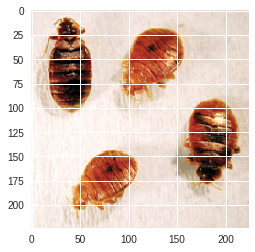

Filename: ./bed-bugsalt.jpg -- VGG Model / Top Results: Label: tick   Probability: 0.9442761 / Next Results Label: cockroach   Probability: 0.03646031
Filename: ./bed-bugsalt.jpg -- Inception Model / Top Results: Label: isopod   Probability: 0.6250367 / Next Results Label: trilobite   Probability: 0.36882338
Filename: ./bed-bugsalt.jpg -- Resnet 50 Model / Top Results: Label: isopod   Probability: 0.50857264 / Next Results Label: cockroach   Probability: 0.3192525


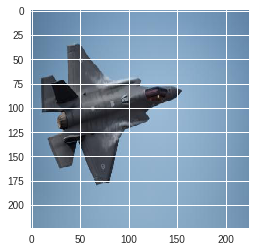

Filename: ./air-combat.jpg -- VGG Model / Top Results: Label: warplane   Probability: 0.9500174 / Next Results Label: wing   Probability: 0.029028641
Filename: ./air-combat.jpg -- Inception Model / Top Results: Label: warplane   Probability: 0.99996114 / Next Results Label: wing   Probability: 1.8563955e-05
Filename: ./air-combat.jpg -- Resnet 50 Model / Top Results: Label: warplane   Probability: 0.95630324 / Next Results Label: wing   Probability: 0.018352695


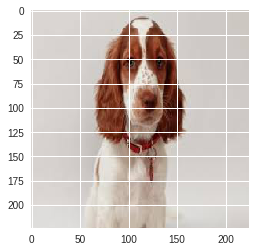

Filename: ./dog.jpg -- VGG Model / Top Results: Label: Welsh_springer_spaniel   Probability: 0.97894096 / Next Results Label: Sussex_spaniel   Probability: 0.011244601
Filename: ./dog.jpg -- Inception Model / Top Results: Label: Welsh_springer_spaniel   Probability: 0.99936885 / Next Results Label: Brittany_spaniel   Probability: 0.00044349913
Filename: ./dog.jpg -- Resnet 50 Model / Top Results: Label: Welsh_springer_spaniel   Probability: 0.699537 / Next Results Label: English_springer   Probability: 0.22482216


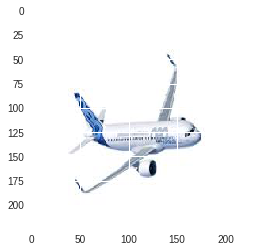

Filename: ./commercial_aircraft.jpg -- VGG Model / Top Results: Label: airliner   Probability: 0.74742115 / Next Results Label: space_shuttle   Probability: 0.09704377
Filename: ./commercial_aircraft.jpg -- Inception Model / Top Results: Label: airliner   Probability: 0.32148618 / Next Results Label: wing   Probability: 0.19032227
Filename: ./commercial_aircraft.jpg -- Resnet 50 Model / Top Results: Label: airliner   Probability: 0.7276575 / Next Results Label: space_shuttle   Probability: 0.23366131


In [151]:
#  MAIN:  Look to see which .jpg files are loaded.  Right now I'm just showing the top two predicted labels with their probabilities.

import os
directory = '/content/images'

for file in os.listdir(directory):
    if file.endswith(".jpg"):
        f = (os.path.join("./", file))
        process_image(f)